In [1]:
%matplotlib inline  
from fastai.vision import *
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from res2fg import *
from ranger import *


Mish activation loaded...


In [2]:
def strt_split(x, y, n_folds=10, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx_10.joblib')
    except:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx_10.joblib')
    return val_name

def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)


def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float, SUFFIX = 'PHASE_1_COS'):
    n = len(learn.data.train_dl)
    anneal_start = int(n*n_epochs*start_pct)
    anneal_end = int(n*n_epochs) - anneal_start
    phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
             TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.callbacks.append(SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}'))
    learn.fit(n_epochs)

In [3]:
PATH = Path('..')
BS =            368
SZ =            224
FOLD =6
EXP_NAME =      f'NB_EXP_60_CV_{FOLD}_{SZ}'
IMG_TRAIN_224 = PATH/f'train_images_3chn_sasan_{SZ}'
IMG_TEST_224  = PATH/f'test_images_3chn_sasan_{SZ}'
DF_TRAIN =      pd.read_csv(PATH/'train_labels_as_strings.csv')
DF_SUBMI =      pd.read_csv(PATH/'stage_1_sample_submission.csv')



DF_SUBMI['fn'] = DF_SUBMI.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.png')
DF_TRAIN['labels'].fillna('', inplace=True)
VAL_IDX = strt_split(DF_TRAIN['fn'], DF_TRAIN['labels'])[FOLD]

In [4]:
ItemList.label_from_df = modified_label_from_df
test_fns = DF_SUBMI.fn.unique()
tfms = get_transforms(max_rotate=180, flip_vert=True, max_zoom=1.4)

data = (ImageList.from_csv('..', 'train_labels_as_strings.csv', folder=IMG_TRAIN_224.name)
        .split_by_idxs(valid_idx=VAL_IDX[0], train_idx=VAL_IDX[1])
        .label_from_df(label_delim=' ')
        .transform(tfms = tfms,size=SZ)
        .add_test('../' +IMG_TEST_224.name + '/' + test_fns)
        .databunch(bs=BS)
        .normalize())

        

In [5]:
md_r2 = res2net(num_classes=data.c)
opt_func = partial(Ranger, betas=(0.92,0.99), eps=1e-6)

Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...


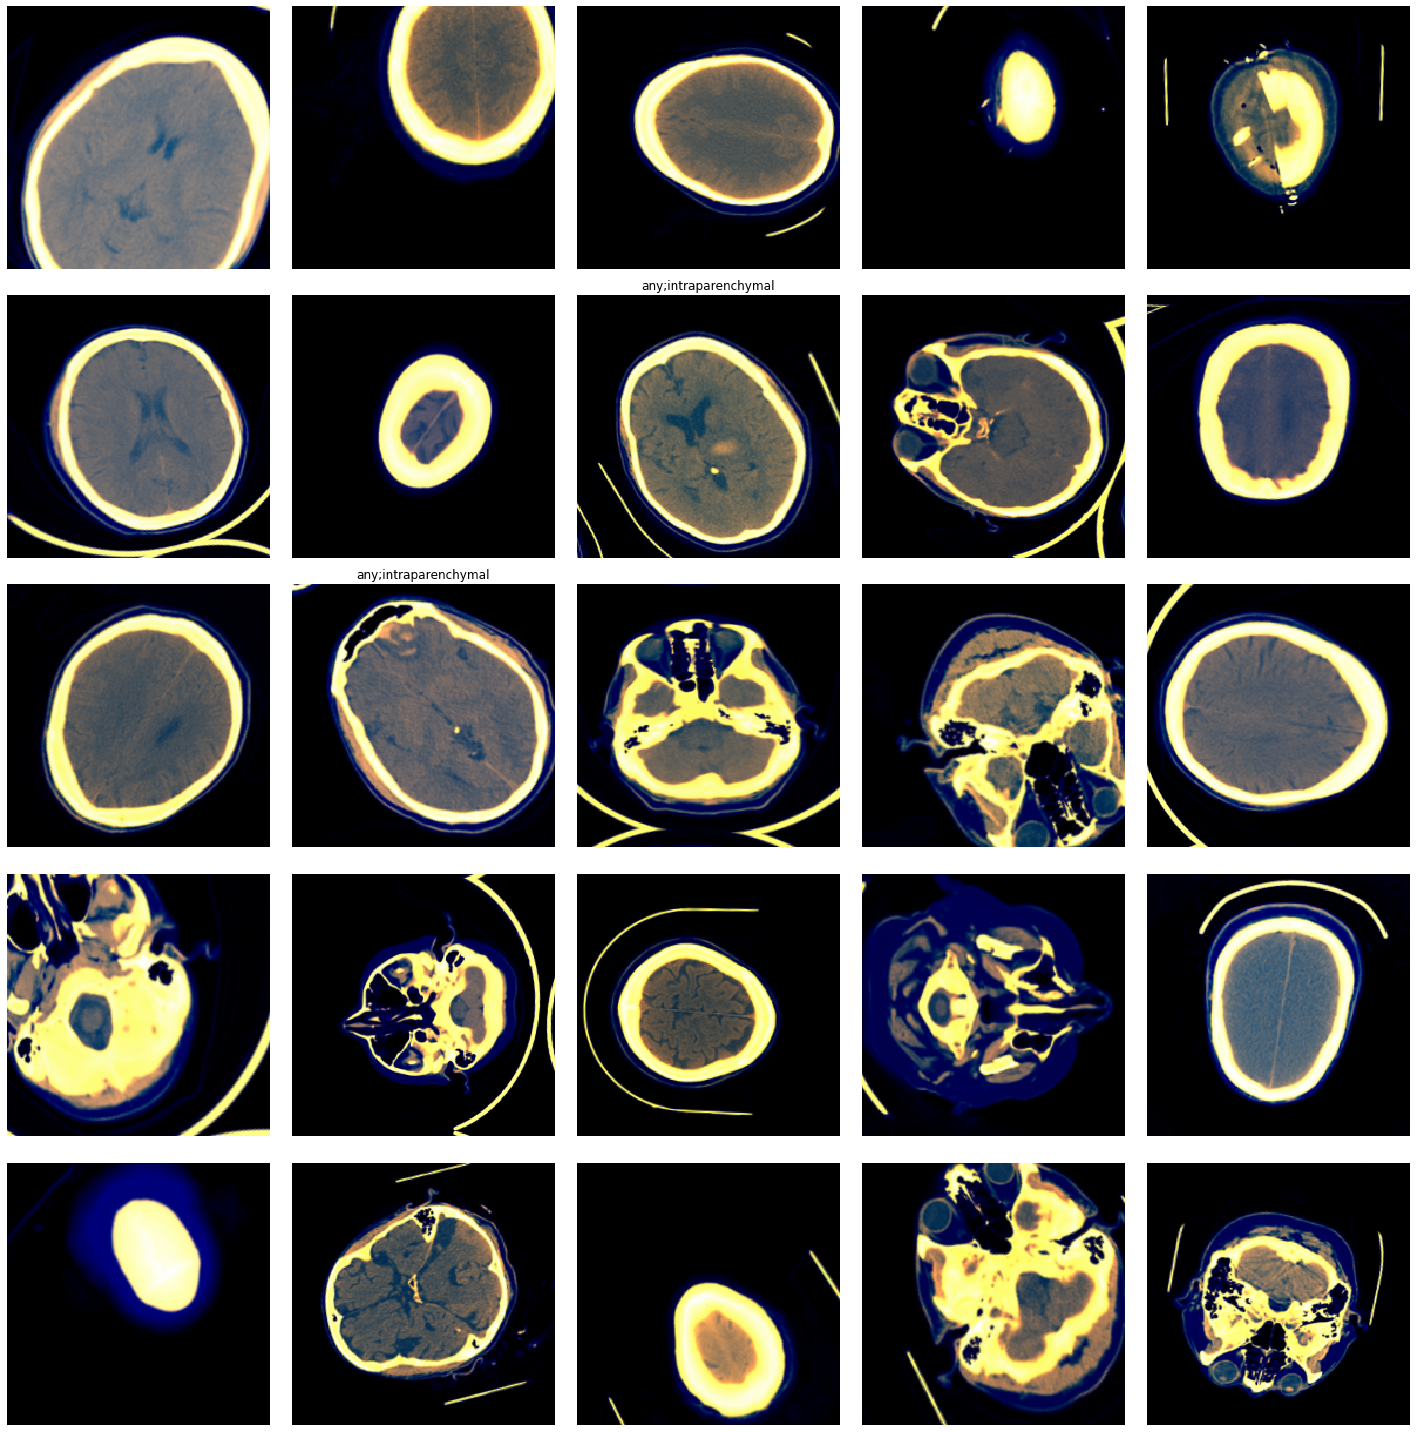

In [6]:
data.show_batch()

In [6]:
learn = Learner(data,
                md_r2,
                wd=1e-3,
                bn_wd=False, 
                true_wd=True, 
                opt_func=opt_func,
                metrics=[accuracy_thresh])

learn.model = nn.DataParallel(learn.model)
learn.to_fp16()
learn.unfreeze()

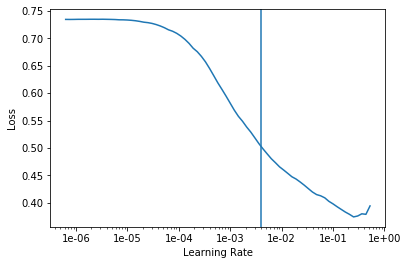

In [10]:
lr = 0.004
learn.recorder.plot()
plt.axvline(lr)

In [7]:
lr = 0.004
flattenAnneal(learn, lr, 30, 0.7)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.108380,0.116708,0.959718,27:22
1,0.091880,0.092789,0.967698,27:24
2,0.085677,0.094117,0.968885,27:10
3,0.080516,0.079532,0.972237,27:09
4,0.077349,0.075900,0.973443,27:39
5,0.076549,0.072789,0.974486,27:08
6,0.073677,0.072817,0.974239,27:30
7,0.071404,0.071171,0.974486,27:04
8,0.068520,0.068483,0.975562,27:21
9,0.068144,0.069353,0.975789,27:40


Better model found at epoch 0 with valid_loss value: 0.11670764535665512.
Better model found at epoch 1 with valid_loss value: 0.09278871864080429.
Better model found at epoch 3 with valid_loss value: 0.07953156530857086.
Better model found at epoch 4 with valid_loss value: 0.07590004056692123.
Better model found at epoch 5 with valid_loss value: 0.07278864830732346.
Better model found at epoch 7 with valid_loss value: 0.07117137312889099.
Better model found at epoch 8 with valid_loss value: 0.06848293542861938.
Better model found at epoch 11 with valid_loss value: 0.0671514943242073.
Better model found at epoch 13 with valid_loss value: 0.06665470451116562.
Better model found at epoch 14 with valid_loss value: 0.06490098685026169.
Better model found at epoch 15 with valid_loss value: 0.06388676166534424.
Better model found at epoch 17 with valid_loss value: 0.06179463118314743.
Better model found at epoch 20 with valid_loss value: 0.061759449541568756.
Better model found at epoch 21 w

In [8]:
def get_preds(learn:Learner, sub_fn: str=f'{EXP_NAME}_PHASE_1_COS', TTA: bool = False, dt_type = DatasetType.Test):
    if TTA:
        learn.to_fp32()
        preds, targs = learn.TTA(ds_type=dt_type)
        sub_fn = f'{sub_fn}_TTA'
    else:
        preds, targs = learn.get_preds(dt_type)
    ids = []
    labels = []

    for fn, pred in zip(test_fns, preds):
        for i, label in enumerate(data.train_ds.classes):
            ids.append(f"{fn.split('.')[0]}_{label}")
            predicted_probability = '{0:1.10f}'.format(pred[i].item())
            labels.append(predicted_probability)
    pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(f'{sub_fn}.csv', index=False)

In [9]:
get_preds(learn)

In [10]:
get_preds(learn, TTA=True)

In [ ]:
!sudo shutdown